# Creating synthetic data from well log

<div align="center">
    <img width=600 src="http://rocksolidimages.com/images/Quantitative-interpretation.png" title="Inputs and outputs for Quantitative Interpretation"</img>
    <small>source: [rocksolid](http://rocksolidimages.com/seismic-services.html)</small>
</div>
<br/>
 
**Starting from a well log, we will create a synthetic dataset of elastic properties (Vp, Vs, density, etc.). **
<br/>

The idea is that the wells cannot possibly sample all the complexity and variations occurring across a reservoir. Using various techniques to synthesize new data and create an _abstraction_ of a considered reservoir we will investigate alternative and plausible scenarios such as: 

- change of pore fluids; 
- lithological variations. 

This kind of technique could also be use to create a training dataset to calibrate 3D seismic volumes (see also the discussion on _training data_ in Avseth et al., 2005, p.126).

This notebook also demonstrates the use of Python to build your own tools and workflows and therefore move away from a "[black-box](http://en.wikipedia.org/wiki/Black_box) approach".

This notebook is based on the [wellMagic package](https://github.com/aadm) from  Alessandro Amato del Monte, Eni E&P.

# Notebook overview

Using IPython we will do these things:

* import well log data and create a new lithology curve log;
* data augmentation through fluid-replacement modeling; 
* description of the reservoir complex under study through statistical analysis;
* creation of a synthetic dataset to replicate the overall behaviour of the reservoir complex.

# Well log data

The well log we will use is part of the test datasets available on the **Quantitative Seismic Interpretation** book website:

<https://pangea.stanford.edu/researchgroups/srb/resources/books/quantitative-seismic-interpretation>

In particular, we will use _"Well 2"_, contained in the _"Project Data"_ zipfile. Plenty of background information for this particular well is available on **Per Avseth's PhD thesis**, again available from the Stanford website:

<https://pangea.stanford.edu/researchgroups/srb/resources/theses>

The actual file we will use in this notebook, `qsiwell2.csv` is an elaboration of several other files contained in that zip archive (merged some logs, created others, etc.) that was created by  Alessandro Amato del Monte (see `qsiwell2_dataprep.py` in the [repo](https://github.com/aadm/geophysical_notes) for details).

Obviously this also possible to do the same type of work using  LAS formated file and the `LAS_reader` package we have been using in the previous notebook.  

First we load the packages and modules we will be using:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Let's load `qsiwell2.csv` into the [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/dev/dsintro.html#dataframe) `WELL`:

In [2]:
WELL = pd.read_csv('WellData/qsiwell2.csv')

to check what's now inside `WELL`:

In [3]:
WELL.columns

Index([u'DEPTH', u'VP', u'VS', u'RHO_OLD', u'GR', u'NPHI', u'RHO', u'SW', u'SWX', u'VPVS', u'IP', u'IS', u'VSH', u'RHOm', u'RHOf', u'PHI'], dtype='object')

We have all the required logs for a quantitative analysis: 

* the elastic logs (compressional and shear velocity `Vp` and `Vs`), 
* the density `RHO` 

as well as the main petrophysical logs: 

* water saturation `Sw`, 
* shale volume `VSH` and 
* porosity `PHI`.

Logs stored into a Pandas DataFrame are easily accessed using the syntax `DataFrame.log`, e.g. `WELL.VP` is the P-wave velocity log and `WELL.PHI` the porosity log.

To select more than one log, use the syntax `DataFrame.[['log1','log2']]`; an alternative is `DataFrame.ix[':',['log1','log2']]` which means selecting all the rows (indicated by `:`) of `log1` and `log2`. This second syntax allows to all kind of crazy selections and filtering like:

* `DataFrame.ix[(DataFrame.Z>=top) & (DataFrame.Z<=bottom)]`: to make a selection on the basis of the Z log (e.g., a depth curve), i.e. to perform a selection on the depth window `top`-`bottom`;
* `DataFrame.ix[DataFrame.class==4,['log1','log2']]`: to get `log1` and `log2` when `class` is 4 (assuming that `class` is a [categorical variable](http://en.wikipedia.org/wiki/Categorical_variable);
* `DataFrame[pd.notnull(DataFrame.log0)].ix[:,'log1','log2']`: to get `log1` and `log2` only when `log0` is not empty.

If I want to remove a specific log (e.g., that `RHO_OLD`) I use the `drop` method with the optional `axis=1` (required otherwise Pandas will search for a _row_ named `TVD` instead of a _column_; ys, Pandas allows):

To rename a log use the `.rename` method:

In [4]:
WELL.rename(columns={'RHOf':'RHOfluid'}, inplace=True)
WELL.columns

Index([u'DEPTH', u'VP', u'VS', u'RHO_OLD', u'GR', u'NPHI', u'RHO', u'SW', u'SWX', u'VPVS', u'IP', u'IS', u'VSH', u'RHOm', u'RHOfluid', u'PHI'], dtype='object')

But what if I need to rename multiple logs? Simply assign a new list of names to the DataFrame columns; for example, if I have a 3 logs called `log1`, `log2`, `log3`, I can rename them all in one go using this syntax:

    DataFrame.columns=['newlog1','newlog2','newlog3']
    
Some other useful functions of Pandas are `DataFrame.describe()`, `DataFrame.log.`.

To inspect the well data we could use standard Python functions (like `min()`, `.max()`, `.mean()`):

In [5]:
print "depth min: %.2f" % WELL.DEPTH.min()
print "depth max: %.2f" %WELL.DEPTH.max()
print "Vp average: %.2f" % WELL.VP.mean()

depth min: 2013.25
depth max: 2640.53
Vp average: 2977.10


...or something useful like the `describe` method:

In [6]:
WELL[['VP','VS','RHO','PHI']].describe()

,VP,VS,RHO,PHI
count,4117.000000,4117.000000,2701.000000,2701.000000
mean,2977.098761,1371.293952,2.225045,0.291759
std,449.355552,297.056552,0.061961,0.032196
min,1439.900000,688.800000,2.036616,0.106844
25%,2594.500000,1141.600000,2.185285,0.276218
50%,3036.100000,1415.300000,2.223544,0.297311
75%,3251.100000,1595.000000,2.264000,0.310519
max,4431.000000,2427.800000,2.545268,0.376396


# Calculating a litho-facies log

We are now going to calculate a _Litho-Fluid Class_ log (LFC), where you will separate groups of data identified by similar lithological and/or pore fluid content. The values of the LFC log will be assigned following these rules:

* LFC=0: undef
* LFC=1: brine sand
* LFC=2: oil sand
* LFC=3: gas sand
* LFC=4: shale

First we restrict the analysis on a smaller depth window (first line in the code snippet below) because the petrophysical logs are not computed everywhere. Then we create the "flag" logs `ssb`, `sso`, `ssg` and `sh`  (i.e., logs made of samples that can only be 1 or 0, i.e. _True_ or _False_) using cut-off values on `VSH` (shale volume) and `SW` (water saturation): 

In [7]:
# Define depth window
WELL = WELL.ix[(WELL.DEPTH>=2100) & (WELL.DEPTH<=2400)]

# Cutoff value for differentiating between sand and shale
sand_cutoff = 0.20

# Sand litho-facies flags
ssb = ( ( WELL.VSH <= sand_cutoff) & (WELL.SW >= 0.9 ) ) # brine sand
sso = ( ( WELL.VSH <= sand_cutoff) & (WELL.SW < 0.9 ) )  # oil sand

# Shales flag
sh=(WELL.VSH > sand_cutoff)                     # shales

Notice that there is no `ssg` log (occurrence of gas sands) yet, as the insitu log did not record any gas sand. We will deal with that later.

We use the above flag logs to create the `LFC` log and store it into `WELL` with the other logs:

In [8]:
temp_lfc = np.zeros( np.shape( WELL.VSH ) )

#  LFC will be 1 when ssb (brine sand flag) is True
temp_lfc[ssb.values] = 1  
  # LFC will be 2 when sso (oil sand flag) is True
temp_lfc[sso.values] = 2    
# LFC will be 4 when sh (shale flag) is True
temp_lfc[sh.values] = 4     

# copy the temporary log temp_lfc into the DataFrame `WELL` with name `LFC`
WELL['LFC'] = temp_lfc        

Now, let's see if this is all ok; the total number of samples after zooming in the 2100-2400 m depth window is:

In [9]:
np.shape( WELL.VSH )

(1968,)

and the following prints out how many samples each facies is made of:

In [10]:
print("brine sst=%d, oil sst=%d, shale=%d" % (np.count_nonzero(ssb),np.count_nonzero(sso),np.count_nonzero(sh)))

brine sst=706, oil sst=134, shale=1128


And a final check to make this newly defined `LFC` log only has values within the range 1 to 4 (there will be no undefined samples in this particular depth interval, i.e. classes with `LFC=0`):

In [11]:
print("LFC min: %d, LFC max: %d" % (WELL.LFC.min(), WELL.LFC.max()))

LFC min: 1, LFC max: 4


Using Pandas, we can plot Vp histograms for each class (remember that at this point we only have classes 1, 2 and 4, i.e. brine sand, oil sand and shales):

array([<matplotlib.axes.AxesSubplot object at 0x7f9a048f8910>,
       <matplotlib.axes.AxesSubplot object at 0x7f9a04527f10>], dtype=object)

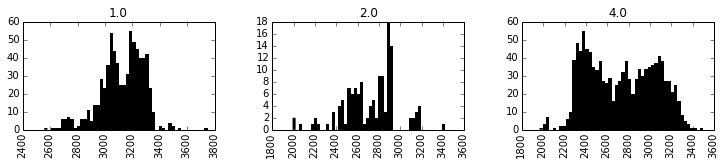

In [12]:
WELL.VP.hist(bins=50, color='black', by=WELL.LFC, figsize=(12,2), layout=(1,3), lw=0)

<font color='red'> **Plot the Vs histogram for each of the class** </font>

# LFC plots

First we define a custom colormap for the classes:

* LFC=0: undef, GRAY
* LFC=1: brine sand, BLUE
* LFC=2: oil sand, GREEN
* LFC=3: gas sand, RED
* LFC=4: shale, BROWN

This is the way to define this colormap:

In [13]:
#  0=undef   1=bri  2=oil   3=gas 4=shale
ccc = ['#B3B3B3','blue','green','red','#996633',]
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

Let's now display a summary view of all the logs:

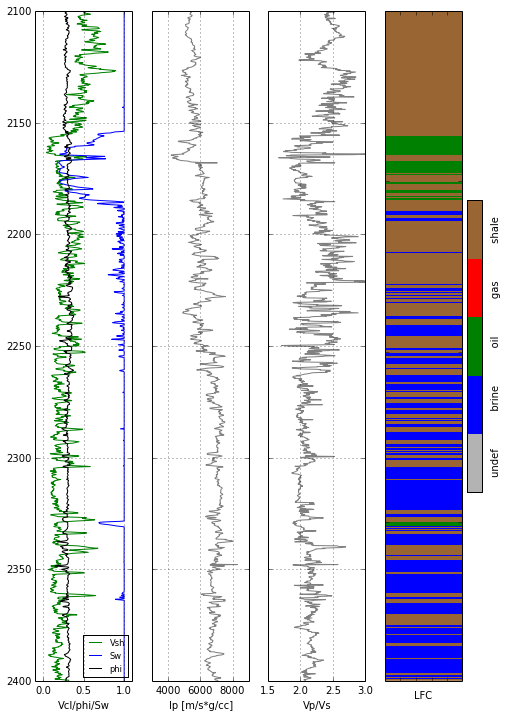

In [14]:
ztop=2100; zbot=2400

# Set the depth window
ll=WELL.ix[(WELL.DEPTH>=ztop) & (WELL.DEPTH<=zbot)]

# Initialise LFC data
cluster=np.repeat(np.expand_dims(ll['LFC'].values,1),100,1)

# Define plot window
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 12))

# Define plot 0: shale volume, water saturation, porosity
ax[0].plot(ll.VSH, ll.DEPTH, '-g', label='Vsh')
ax[0].plot(ll.SW, ll.DEPTH, '-b', label='Sw')
ax[0].plot(ll.PHI, ll.DEPTH, '-k', label='phi')

# Define plot 1: acoustic impedance. (Ip)
ax[1].plot(ll.IP, ll.DEPTH, '-', color='0.5')

# Define plot 2: VpVs ratio
ax[2].plot(ll.VPVS, ll.DEPTH, '-', color='0.5')

# Define plot 3: set colormap
im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

# Define plot 3 color bar
cbar=plt.colorbar(im, ax=ax[3])
# cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
# cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1))
cbar.set_label((12*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

# Define Depth (y-axis)
for i in ax[:-1]:
    i.set_ylim(ztop,zbot)
    i.invert_yaxis()
    i.grid()
    i.locator_params(axis='x', nbins=4)
    
# Define legend and x-axis ranges
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel("Vcl/phi/Sw"),    ax[0].set_xlim(-.1,1.1)
ax[1].set_xlabel("Ip [m/s*g/cc]"), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel("Vp/Vs"),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('LFC')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([]);

Now let's see the same data in crossplot domain that should be familiar to geophysicists, i.e. acoustic impedance (Ip) versus Vp/Vs ratio:

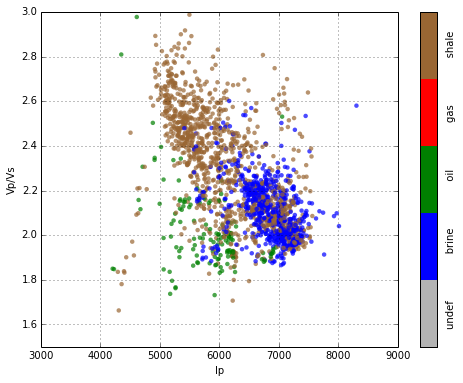

In [15]:
plt.figure(figsize=(8,6))

plt.scatter(WELL.IP,WELL.VPVS,20,WELL.LFC,marker='o',edgecolors='none',alpha=0.7,cmap=cmap_facies,vmin=0,vmax=4)

plt.xlim(3000,9000); plt.ylim(1.5,3); plt.grid(); plt.xlabel('Ip'); plt.ylabel('Vp/Vs')

cbar=plt.colorbar()
# cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
# cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1));

cbar.set_label((15*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
cbar.set_alpha(1)
cbar.draw_all()

## Interactive plot

The following code builds a summary plot showing the following tracks, from left to right:

1. petrophysical logs
2. Ip log
3. Vp/Vs log
4. litho-facies class

To the extreme right we have an interactive Ip-Vp/Vs crossplot; two sliders are used to select top and bottom limits (in meters) of the analysis window where data is dynamically taken to populate this crossplot.

As a visual aid, the extend of the analysis window is displayed as a transparent rectangle in the first track.

Select top (z1) and bottom (z2) of analysis window to populate Ip-Vp/Vs crossplot.
Analysis window will be highlighted in yellow in leftmost track.


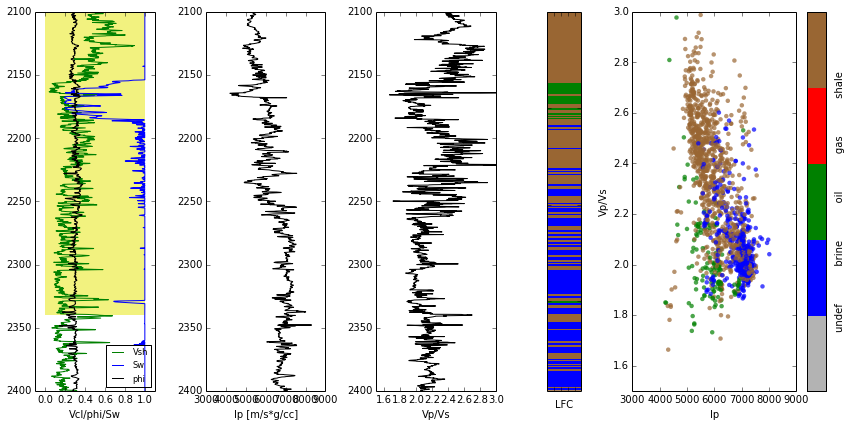

In [16]:
def crossplot(z1=2040,z2=2340):
    from matplotlib.patches import Rectangle
    ll=WELL.ix[(WELL.DEPTH>=2000) & (WELL.DEPTH<=2400)]
    cluster=np.repeat(np.expand_dims(ll['LFC'].values,1),100,1)
    
    fig = plt.figure(figsize=(12, 6))
    ax0 = plt.subplot2grid((1,10), (0,0), colspan=2)
    ax1 = plt.subplot2grid((1,10), (0,2), colspan=2,sharey=ax0)
    ax2 = plt.subplot2grid((1,10), (0,4), colspan=2,sharey=ax0)
    ax3 = plt.subplot2grid((1,10), (0,6))
    ax4 = plt.subplot2grid((1,10), (0,7), colspan=3)
    
    ax0.plot(ll.VSH, ll.DEPTH, '-g', label='Vsh')
    ax0.plot(ll.SW, ll.DEPTH, '-b', label='Sw')
    ax0.plot(ll.PHI, ll.DEPTH, '-k', label='phi')
    ax1.plot(ll.IP, ll.DEPTH, '-k')
    ax2.plot(ll.VPVS, ll.DEPTH, '-k')
    im=ax3.imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)  
    ll=WELL.ix[(WELL.DEPTH>=z1) & (WELL.DEPTH<=z2)]
    ax4.scatter(ll.IP,ll.VPVS,20,ll.LFC,marker='o',edgecolors='none',alpha=0.7,cmap=cmap_facies,vmin=0,vmax=4)

    ax0.invert_yaxis(), ax3.set_yticklabels([]), ax3.set_xticklabels([])
    ax0.legend(fontsize='small', loc='lower right')
    ax0.set_xlabel('Vcl/phi/Sw'),ax0.set_xlim(-.1,1.1)
    ax1.set_xlabel('Ip [m/s*g/cc]'),ax1.set_xlim(3000,9000)
    ax2.set_xlabel('Vp/Vs'),ax2.set_xlim(1.5,3)
    ax3.set_xlabel('LFC')
    ax4.set_xlabel('Ip'),ax4.set_ylabel('Vp/Vs'),ax4.set_xlim(3000,9000),ax4.set_ylim(1.5,3); 
    fig.tight_layout() 
    
    cbar=plt.colorbar(im, ax=ax4)
#     cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
#     cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1));
    cbar.set_label((12*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    ax0.add_patch(Rectangle((0, z1),1,z2-z1,edgecolor='None',facecolor=[0.9,0.9,0.0],alpha=0.5))

interact(crossplot, z1=(2000,2360,40),z2=(2040,2400,40))
print('Select top (z1) and bottom (z2) of analysis window to populate Ip-Vp/Vs crossplot.')
print('Analysis window will be highlighted in yellow in leftmost track.')

As you can see we don't have any insitu gas sands (red). Let's go make some of those...

# Fluid replacement modeling

## Gassmann's equation

Fluid replacement modeling (FRM in short), based on [Gassmann's equation](http://cseg.ca/assets/files/resources/abstracts/2013/316_GC2013_A_look_into_Gassmanns_Equation.pdf), is one of the key activities for any kind of quantitative work (see Wang, 2001 and Smith et al., 2003, for an exhaustive overview).

<div align="center">
    <img width=400 src="http://geophysics.geoscienceworld.org/content/69/2/398/F3.medium.gif" title="Illustration of both the Voigt high and Reuss low bounds for dry rock, fluid-saturated rock, and bounds of predicted fluid-saturation effect by the Gassmann's equation."</img>
    <small>source: [Geophysics](http://geophysics.geoscienceworld.org)</small>
</div>
<br/>


It is used to model the response of elastic logs (i.e., Vp, Vs and density) in different fluid conditions, thus allowing to study how much a rock would change in terms of velocity (or impedances) if it was filled with gas instead of brine for example; but what it also does is to bring all elastic logs to a *common fluid denominator* to focus only on lithological variations, disregarding fluid effects.

The inputs to FRM are $k_s$ and $\mu_s$ (saturated bulk and shear moduli which we can get from recorded Vps, Vs and density logs), $k_d$ and $\mu_d$ (dry-rock bulk and shear moduli), $k_0$ (mineral bulk modulus), $k_f$ (fluid bulk modulus) and porosity, $\varphi$. Reasonable estimates of mineral and fluid bulk moduli and porosity are easily computed and are shown below. The real unknowns, what is arguably the core issue of rock physics, are the dry-rock moduli.

And here we come to Gassmann's equation; the dry-rock bulk modulus $k_d$ can be obtained from:

$$ k_d = \frac{k_s \cdot ( \frac{\varphi k_0}{k_f} +1-\varphi) -k_0}{\frac {\varphi k_0}{k_f} + \frac{k_s}{k_0} -1-\varphi} $$

Then the saturated bulk modulus $k_s$ with the new fluid is derived from:

$$k_s = k_d + \frac { (1-\frac{k_d}{k_0})^2} { \frac{\varphi}{k_f} + \frac{1-\varphi}{k_0} - \frac{k_d}{k_0^2}}$$

Shear modulus is not affected by pore fluid so that it stays unmodified throughout the fluid replacement process.

$$\mu_s = \mu_d$$

Bulk density is defined via the following equation:

$$\rho = (1-\varphi) \cdot \rho_0 + \varphi \cdot \rho_f $$

And this is how we define it all as a Python function:

In [25]:
# Fluid replacement modeling function
def frm(vp1, vs1, rho1, rho_fl1, k_fl1, rho_fl2, k_fl2, km, phi):
    vp1=vp1/1000
    vs1=vs1/1000
    rho2 = rho1-phi*rho_fl1+phi*rho_fl2
    mu1 = rho1*vs1**2.
    k1 = rho1*vp1**2-(4./3.)*mu1
    kdry= (k1 * ((phi*k0)/k_fl1+1-phi)-k0) / ((phi*k0)/k_fl1+(k1/k0)-1-phi)
    k2 = kdry + (1- (kdry/k0))**2 / ( (phi/k_fl2) + ((1-phi)/k0) - (kdry/k0**2) )
    mu2 = mu1
    vp2 = np.sqrt(((k2+(4./3)*mu2))/rho2)
    vs2 = np.sqrt((mu2/rho2))
    return [vp2*1000, vs2*1000, rho2, k2]

What this function does is to get the relevant inputs which are:

* `vp1`, `vs1`, `rho1`: measured Vp, Vs, and density (saturated with fluid 1)
* `rho_fl1`, `k_fl1`: density and bulk modulus of fluid 1
* `rho_fl2`, `k_fl2`: density and bulk modulus of fluid 2
* `k0`: mineral bulk modulus
* `phi`:  porosity

And returns `vp2`,`vs2`, `rho2`, `k2` which are respectively Vp, Vs, density and bulk modulus of rock with fluid 2.

## Voigt-Reuss-Hill averaging

One assumption in Gassmann's equation is that it works only on monomineralic rock. However an actual rock is always a mixture of different minerals. A good approximation to get a mixed mineralogy bulk modulus `k0` is to use Voigt-Reuss-Hill averaging (check [these notes](https://pangea.stanford.edu/courses/gp262/Notes/9.EffectiveMediumTheories.pdf) by [Jack Dvorkin](http://pangea.stanford.edu/~jack/) for a more rigorous discussion or [this wikipedia entry](http://en.wikipedia.org/wiki/Rule_of_mixtures)).

So we code another function, `vrh`, to do that:

In [28]:
# Voigt-Reuss-Hill averaging equation
def vrh(volumes,k,mu):
    f=np.array(volumes).T
    k=np.resize(np.array(k),np.shape(f))
    mu=np.resize(np.array(mu),np.shape(f))

    k_u = np.sum(f*k,axis=1)
    k_l = 1./np.sum(f/k,axis=1)
    mu_u = np.sum(f*mu,axis=1)
    mu_l = 1./np.sum(f/mu,axis=1)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return [k_u, k_l, mu_u, mu_l, k0, mu0]

We can use the same function to also compute the fluid bulk modulus log which is usually done via Reuss average (the lower bound `k_l` in the `vrh` function above):

First we need to define the various mineral and fluid elastic constants:

In [29]:
rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine
rho_o=0.78;   k_o=0.94              # fluid properties, oil
rho_g=0.25;   k_g=0.06              # fluid properties, gas

Then we  calculate the original (insitu) fluid density `rho_fl` and bulk modulus `k_fl`, and the average mineral bulk modulus `k0`:

In [30]:
# mineral mixture bulk and shear moduli, k0 and mu0
shale=WELL.VSH.values
sand=1-shale-WELL.PHI.values
shaleN = shale/(shale+sand)  # normalized shale and sand volumes
sandN  = sand/(shale+sand)

# Voigt-Reuss-Hill averaging
[k_u, k_l, mu_u, mu_l, k0, mu0]=vrh([shaleN, sandN],[k_sh,k_qz],[mu_sh,mu_qz])

# fluid mixture bulk modulus, using the same vrh function but capturing the Reuss average (second output)
water=WELL.SW.values
hc=1-WELL.SW.values
[tmp, k_fl, tmp, tmp, tmp, tmp]=vrh([water, hc],[k_b,k_o],[0,0])

# fluid mixture density
rho_fl=water*rho_b + hc*rho_o

...and put it all together using the `frm` function defined above:

In [32]:
[vpb, vsb, rhob, kb] = frm(WELL.VP, WELL.VS, WELL.RHO, rho_fl, k_fl, rho_b, k_b, k0, WELL.PHI)
[vpo, vso, rhoo, ko] = frm(WELL.VP, WELL.VS, WELL.RHO, rho_fl, k_fl, rho_o, k_o, k0, WELL.PHI)
[vpg, vsg, rhog, kg] = frm(WELL.VP, WELL.VS, WELL.RHO, rho_fl, k_fl, rho_g, k_g, k0, WELL.PHI)

## _Augmented_ well dataset

Now we create 3 sets of copies of the original elastic logs stored in my DataFrame `WELL` (`WELL.VP`, `WELL.VSB`, `WELL.RHO`) for the three fluid scenarios investigated (and we will append an appropriate suffix to identify these 3 cases, i.e. `_FRMB` for brine, `_FRMG` for gas and `_FRMO` for oil, respectively).

These three sets will be placeholders to store the values of the actual fluid-replaced logs (`vpb`, `vsb`, `rhob`, etc.).

The syntax we use to do this is:

    WELL['VP_FRMB'][ssb|sso]=vpb[ssb|sso]
    
Which means, copy the values from the output of fluid replacement (`vpb`, `vsb`, `rhob`, etc.) only where there's sand (`vpb[ssb|sso]`), i.e. only when either the flag logs `ssb` or `sso` are _True_).

We also compute the additional elastic logs (acoustic and shear impedances `IP`, `Is`, and Vp/Vs ratio, `VPVS`) in their fluid-replaced version.

In [33]:
WELL['VP_FRMB']=WELL.VP
WELL['VS_FRMB']=WELL.VS
WELL['RHO_FRMB']=WELL.RHO
WELL['VP_FRMB'][ssb|sso]=vpb[ssb|sso]
WELL['VS_FRMB'][ssb|sso]=vsb[ssb|sso]
WELL['RHO_FRMB'][ssb|sso]=rhob[ssb|sso]
WELL['IP_FRMB']=WELL.VP_FRMB*WELL.RHO_FRMB
WELL['IS_FRMB']=WELL.VS_FRMB*WELL.RHO_FRMB
WELL['VPVS_FRMB']=WELL.VP_FRMB/WELL.VS_FRMB

WELL['VP_FRMO']=WELL.VP
WELL['VS_FRMO']=WELL.VS
WELL['RHO_FRMO']=WELL.RHO
WELL['VP_FRMO'][ssb|sso]=vpo[ssb|sso]
WELL['VS_FRMO'][ssb|sso]=vso[ssb|sso]
WELL['RHO_FRMO'][ssb|sso]=rhoo[ssb|sso]
WELL['IP_FRMO']=WELL.VP_FRMO*WELL.RHO_FRMO
WELL['IS_FRMO']=WELL.VS_FRMO*WELL.RHO_FRMO
WELL['VPVS_FRMO']=WELL.VP_FRMO/WELL.VS_FRMO

WELL['VP_FRMG']=WELL.VP
WELL['VS_FRMG']=WELL.VS
WELL['RHO_FRMG']=WELL.RHO
WELL['VP_FRMG'][ssb|sso]=vpg[ssb|sso]
WELL['VS_FRMG'][ssb|sso]=vsg[ssb|sso]
WELL['RHO_FRMG'][ssb|sso]=rhog[ssb|sso]
WELL['IP_FRMG']=WELL.VP_FRMG*WELL.RHO_FRMG
WELL['IS_FRMG']=WELL.VS_FRMG*WELL.RHO_FRMG
WELL['VPVS_FRMG']=WELL.VP_FRMG/WELL.VS_FRMG

Finally, we will add three more LFC logs that will be companions to the new fluid-replaced logs. 

The LFC log for brine-replaced logs will be always 1 whenever there's sand, because fluid replacement will have acted on all sand points and replaced whatever fluid we had originally with brine. Same thing for `LFC_O` and `LFC_G` (LFC for oil and gas-replaced logs): they will always be equal to 2 (oil) or 3 (gas) for all the sand samples. That translates into Python like:

In [34]:
temp_lfc_b=np.zeros(np.shape(WELL.VSH))
temp_lfc_b[ssb.values | sso.values]=1  # LFC is 1 when either ssb (brine sand flag) or sso (oil) is True
temp_lfc_b[sh.values]=4                # LFC 4=shale
WELL['LFC_B']= temp_lfc_b

temp_lfc_o=np.zeros(np.shape(WELL.VSH))
temp_lfc_o[ssb.values | sso.values]=2  # LFC is now 2 when there's sand (ssb or sso is True)
temp_lfc_o[sh.values]=4                # LFC 4=shale
WELL['LFC_O']= temp_lfc_o

temp_lfc_g=np.zeros(np.shape(WELL.VSH))
temp_lfc_g[ssb.values | sso.values]=3  # LFC 3=gas sand
temp_lfc_g[sh.values]=4                # LFC 4=shale
WELL['LFC_G']= temp_lfc_g

And using the same summary plot we have used above, updated to show the fluid changes in the elastic logs Ip and Vp/Vs. It is also zoomed into the reservoir between 2150 and 2200 m, and the LFC log is the original one, i.e. it reflects the insitu case.

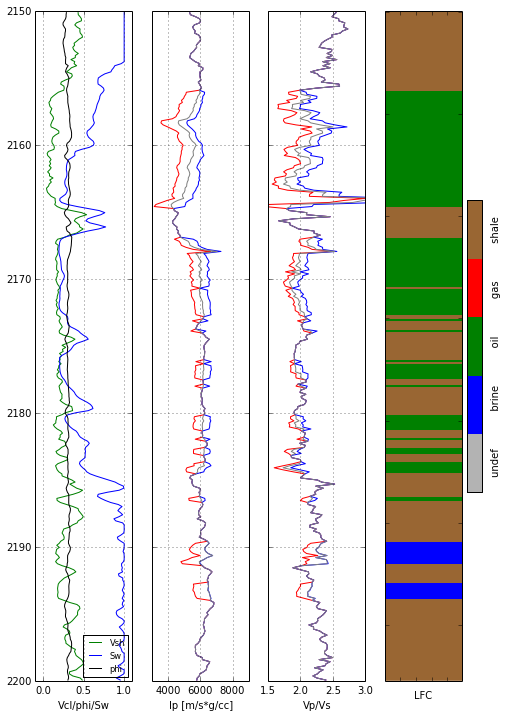

In [36]:
ztop=2150; zbot=2200
ll=WELL.ix[(WELL.DEPTH>=ztop) & (WELL.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['LFC'].values,1),100,1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 12))
ax[0].plot(ll.VSH, ll.DEPTH, '-g', label='Vsh')
ax[0].plot(ll.SW, ll.DEPTH, '-b', label='Sw')
ax[0].plot(ll.PHI, ll.DEPTH, '-k', label='phi')
ax[1].plot(ll.IP_FRMG, ll.DEPTH, '-r')
ax[1].plot(ll.IP_FRMB, ll.DEPTH, '-b')
ax[1].plot(ll.IP, ll.DEPTH, '-', color='0.5')
ax[2].plot(ll.VPVS_FRMG, ll.DEPTH, '-r')
ax[2].plot(ll.VPVS_FRMB, ll.DEPTH, '-b')
ax[2].plot(ll.VPVS, ll.DEPTH, '-', color='0.5')
im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)
cbar=plt.colorbar(im, ax=ax[3])
# cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
# cbar.set_ticks(range(0,4+1)); 
cbar.set_label((12*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
for i in ax[:-1]:
    i.set_ylim(ztop,zbot)
    i.invert_yaxis()
    i.grid()
    i.locator_params(axis='x', nbins=4)
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel("Vcl/phi/Sw"),    ax[0].set_xlim(-.1,1.1)
ax[1].set_xlabel("Ip [m/s*g/cc]"), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel("Vp/Vs"),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('LFC')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([]);

Let's have a look at the results in the Ip versus Vp/Vs crossplot domain; I will now plot 4 different plots to compare the initial situation to the results of the 4 fluid replacements:

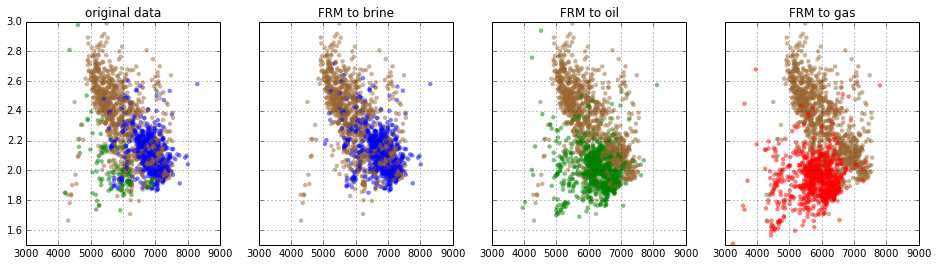

In [38]:
f, ax = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(16, 4))
ax[0].scatter(WELL.IP,WELL.VPVS,20,WELL.LFC,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[1].scatter(WELL.IP_FRMB,WELL.VPVS_FRMB,20,WELL.LFC_B,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[2].scatter(WELL.IP_FRMO,WELL.VPVS_FRMO,20,WELL.LFC_O,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[3].scatter(WELL.IP_FRMG,WELL.VPVS_FRMG,20,WELL.LFC_G,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[0].set_xlim(3000,9000); ax[0].set_ylim(1.5,3);
ax[0].set_title('original data');
ax[1].set_title('FRM to brine');
ax[2].set_title('FRM to oil');
ax[3].set_title('FRM to gas');
for i in ax: i.grid()

# Statistical analysis

## Generalities

After the Fluid Replacement Modeling we have created an _augmented_ dataset. What we need to do now is to do a further abstraction, i.e. moving away from the local irregularities of the real data with the final goal of creating a **fully synthetic dataset representing an idealized version of a reservoir complex**.

To do that we will do a statistical analysis to describe [tendency](http://en.wikipedia.org/wiki/Central_tendency), [dispersion](http://en.wikipedia.org/wiki/Statistical_dispersion) and [correlation](http://en.wikipedia.org/wiki/Correlation_and_dependence) between certain elastic properties for each litho-fluid class.

Central tendency is simply described by calculating the mean values of some desired elastic property for all the existing classes; dispersion and correlation are summarised with the _covariance matrix_, which can be written like this (for two generic variables X and Y):

    [ var_X     cov_XY ]
    [ cov_XY    var_Y  ]

if we had _three_ variables instead:

    [ var_X     cov_XY    cov_XZ ]
    [ cov_XY    var_Y     cov_YZ ]
    [ cov_XZ    cov_YZ    var_Z  ]

Where `var_X` is the [variance](http://en.wikipedia.org/wiki/Variance) of property X, i.e. a measure of dispersion about the mean, while the [covariance](http://en.wikipedia.org/wiki/Covariance) `cov_XY` is a measure of similarity between two properties X and Y. A detailed description of the covariance matrix can be found at [this wikipedia entry](http://en.wikipedia.org/wiki/Covariance_matrix).

Python allows to easily perform these calculations, but what we need is a way to to store this matrix in a way that is easily accessible (which will be another Pandas DataFrame). To do this we first linearize the matrices removing the duplicates, to get something like this (example for the 2-variable scenario):

    var_X  cov_XY  cov_XY var_Y

## Implementation in python

For the rest of this exercise we will work with the two variables used so far, i.e. Ip and Vp/Vs.

First we need to prepare a few things to make the procedure easily extendable to other situations (e.g., using more than two variables):

1. collect all the insitu and fluid-replaced logs together to create a _megalog_;
2. create a Pandas DataFrame to hold statistical information for all the litho-fluid classes.

Step 1 works like this:

In [41]:
lognames0=['LFC','IP','VPVS']
lognames1=['LFC_B','IP_FRMB', 'VPVS_FRMB']
lognames2=['LFC_O','IP_FRMO', 'VPVS_FRMO']
lognames3=['LFC_G','IP_FRMG', 'VPVS_FRMG']
ww0=WELL[pd.notnull(WELL.LFC)].ix[:,lognames0];
ww1=WELL[pd.notnull(WELL.LFC)].ix[:,lognames1];  ww1.columns=[lognames0]
ww2=WELL[pd.notnull(WELL.LFC)].ix[:,lognames2];  ww2.columns=[lognames0]
ww3=WELL[pd.notnull(WELL.LFC)].ix[:,lognames3];  ww3.columns=[lognames0]
ww=pd.concat([ww0, ww1, ww2, ww3])

What we have done here is to first define 3 lists containing the names of the logs we want to extract (lines 1-4). Then we extract into 4 separate temporary DataFrames (lines 5-8) different sets of logs, e.g. `ww0` will contain only the logs `LFC`,`IP`,`VPVS`, and `ww1` will hold only `LFC_B`,`IP_FRMB`, `VPVS_FRMB`. We will also rename the fluid-replaced logs to have the same name as pir insitu logs using `ww1.columns=[lognames0]`. In this way, when we merge all these 3 DataFrame together (line 9) we will have created a megalog (`ww`) that includes all values of Ip and Vp/Vs that are both measured for a certain facies, and synthetically created through fluid substitution.

In other words, we have now a data-augmented megalog.

Now, on to step 2:

In [42]:
nlfc=int(ww.LFC.max())
nlogs=len(ww.columns)-1    # my merged data always contain a facies log...
                           # ...that needs to be excluded from the statistical analysis
names_mean=['']*nlogs      # create empty list of strings that...
                           #...will form the headers for the columns containing the mean
names_cov=['']*nlogs*nlogs # same as above but for the columns containing the covariance
for i,aa in enumerate(names_mean):  # populate names_mean with unique names, from mean0 to mean3
    names_mean[i]='mean'+str(i)
for i,aa in enumerate(names_cov):   # populate names_cov with unique names, from cov0 to cov15
    names_cov[i]='cov'+str(i)        

With the code above we simply build the headers for a Pandas DataFrame to store mean and covariances for each class.

We will now create a DataFrame which is dynamically dimensioned and made of `nfacies` rows, i.e. one row per each facies, and `1+n+m+1` columns, where `n` is the number of mean columns and `m` is the length of the linearized covariance matrix; for our sample case where we have only two properties this means:

* 1 column to store the facies number;
* 2 columns (from 2 to 3) to store mean values for each of the four logs;
* 6 columns (from 4 to 9) to store covariance values for each combination of the four logs;
* 1 column (10) to store the number of samples belonging to each facies as a way to control the robustness of our statistical analysis (i.e., undersampled classes could be taken out of the study).

In [44]:
stat=pd.DataFrame(data=None,
    columns=['LFC']+names_mean+names_cov+['SAMPLES'],
    index=np.arange(nlfc))
stat['LFC']=range(1,nlfc+1)

This is how the `stat` DataFrame looks like now:

In [45]:
stat

,LFC,mean0,mean1,cov0,cov1,cov2,cov3,SAMPLES
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So it's like an empty box, made of four rows (because we have 4 classes: shale, brine, oil and gas sands), and for each row we have space to store the mean values of property n.1 (Ip) and n.2 (Vp/Vs), plus their covariances and the number of samples for each class (that will inform me on the robustness of the analysis, i.e. if I have too few samples then I need to consider how my statistical analysis will not be reliable).

The following snippet shows how to populate `stat` and get a few plots to control if everything makes sense; also note the use of `.flatten()` at line 5 that linearize the covariance matrix as discussed above, so that we can save it in a series of contiguous cells along a row of `stat`:

In [46]:
for i in range(1,nlfc+1):
    temp=ww[ww.LFC==i].drop('LFC',1)
    stat.ix[(stat.LFC==i),'SAMPLES']=temp.count()[0]
    stat.ix[stat.LFC==i,names_mean[0]:names_mean[-1]]=np.mean(temp.values,0)
    stat.ix[stat.LFC==i,names_cov[0]:names_cov[-1]]=np.cov(temp,rowvar=0).flatten()
    print (temp.describe().ix['mean':'std'])
    print ("LFC=%d, number of samples=%d" % (i, temp.count()[0]))

               IP      VPVS
mean  6790.205433  2.114032
std    446.901335  0.143257
LFC=1, number of samples=1546
               IP      VPVS
mean  6184.984928  2.006645
std    581.027454  0.153004
LFC=2, number of samples=974
               IP      VPVS
mean  5816.300762  1.939004
std    600.000944  0.142885
LFC=3, number of samples=840
               IP      VPVS
mean  6087.850787  2.316682
std    701.800996  0.237249
LFC=4, number of samples=4512


Now let's look back at `stat` and see how it has been filled up with all the information we need:    

In [47]:
stat

,LFC,mean0,mean1,cov0,cov1,cov2,cov3,SAMPLES
0,1,6790.205,2.114032,199720.8,-27.95407,-27.95407,0.02052249,1546
1,2,6184.985,2.006645,337592.9,-16.72487,-16.72487,0.02341014,974
2,3,5816.301,1.939004,360001.1,8.667817,8.667817,0.020416,840
3,4,6087.851,2.316682,492524.6,-98.02494,-98.02494,0.05628693,4512


We can also interrogate `stat` to know for example the average Ip for the litho-fluid class 2 (brine sands):

In [48]:
stat.ix[stat.LFC==2,'mean0']

1    6184.985
Name: mean0, dtype: object

Obviously we need to remember that the _first_ property is Ip, so that's why I am querying the column `mean0` (`mean1` holds the average values for the _second_ property, in this case Vp/Vs).

If we were working with 3 properties, e.g. Ip, Vp/Vs and density, then the average density value for a hypothetical class 5 would be: `stat.ix[stat.LFC==5,'mean2']`; remember that Python works with zero-based lists and vectors so the first one has always an index of 0.

To display graphically the same information we use Pandas' `scatter_matrix`:

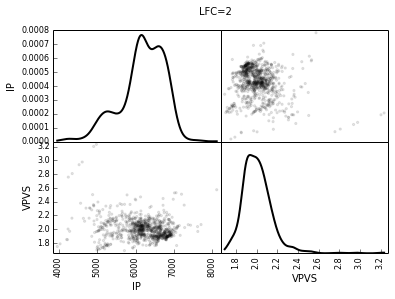

In [49]:
i=2
pd.scatter_matrix(ww[ww.LFC==i].drop('LFC',1), color='black', diagonal='kde', alpha=0.1, density_kwds={'color':'#000000','lw':2})
plt.suptitle('LFC=%d' % i)

# Creation of synthetic datasets

We can now use all this information to create a brand new synthetic dataset that will replicate the average behaviour of the reservoir complex and at the same time overcome typical problems when using real data like undersampling of a certain class, presence of outliers, spurious occurrence of anomalies.

To create the synthetic datasets we use a Monte Carlo simulation relying on [multivariate normal distribution](http://en.wikipedia.org/wiki/Multivariate_normal_distribution) to draw samples that are random but correlated in the elastic domain of choice (Ip and Vp/Vs).

In [50]:
NN=300

mc=pd.DataFrame(data=None,
    columns=lognames0,
    index=np.arange(nlfc*NN), dtype='float')

for i in range(1,nlfc+1):
    mc.loc[NN*i-NN:NN*i-1,'LFC']=i
    
for i in range(1,nlfc+1):
    mean =             stat.loc[i-1,names_mean[0]:names_mean[-1]].values
    sigma = np.reshape(stat.loc[i-1,names_cov[0]:names_cov[-1]].values,(nlogs,nlogs))
    mc.ix[mc.LFC==i,1:] = np.random.multivariate_normal(mean,sigma,NN)

First we define how many samples per class I want (line 1), then we create an empty Pandas DataFrame (lines 3-5) dimensioned like this:

* as many columns as the elastic logs we have chosen: in this case, 3 (`LFC`, `IP` and `VPVS`, stored in `lognames0`, previously used to dimension the `stat` DataFrame);
* the total number of rows will be equal to number of samples (e.g., 100) multiplied by the number of classes (4).

In lines 7-8 we fill in the `LFC` column with the numbers assigned to each class. We use the `nlfc` variable that contains the total number of classes, introduced earlier when creating the `stat` DataFrame; then I loop over the range 1 to `nlfc` , and assign 1 to rows 1-299, 2 to 300-599, and so on.

Lines 10-13 are the core of the entire procedure. For each class (another loop over the range 1-`nlfc`) we extract the average value `mean` and the covariance matrix `sigma` from the `stat` DataFrame, then put them into the [Numpy](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html) `np.random.multivariate_normal` method to draw randomly selected samples from the continuous and correlated distributions of the properties Ip and Vp/Vs.

So the `mc` DataFrame will be made of 3 columns (`LFC`, `IP`, `VPVS`) by 1200 rows (we can look at the dimensions with `.shape` and then have an overview of the matrix with `.describe` discussed earlier):

In [51]:
mc.describe()

,LFC,IP,VPVS
count,1200.0000,1200.000000,1200.000000
mean,2.5000,6180.459921,2.099505
std,1.1185,690.699262,0.223286
min,1.0000,3795.546148,1.535407
25%,1.7500,5691.511156,1.943926
50%,2.5000,6203.849267,2.073994
75%,3.2500,6654.584551,2.227624
max,4.0000,7956.611768,2.988771


And these are the results, comparing the original, augmented dataset (i.e. the results of fluid replacement merged with the insitu log, all stored in the DataFrame `ww` defined earlier when calculating the statistics) with the newly created synthetic data:

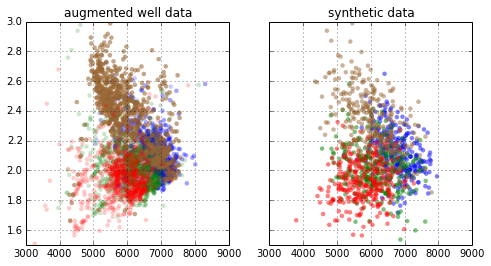

In [52]:
f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 4))
scatt1=ax[0].scatter(ww.IP,ww.VPVS,20,ww.LFC,marker='o',edgecolors='none', alpha=0.2, cmap=cmap_facies,vmin=0,vmax=4)
scatt2=ax[1].scatter(mc.IP,mc.VPVS,20,mc.LFC,marker='o',edgecolors='none', alpha=0.5, cmap=cmap_facies,vmin=0,vmax=4)
ax[0].set_xlim(3000,9000); ax[0].set_ylim(1.5,3.0);
ax[0].set_title('augmented well data');
ax[1].set_title('synthetic data');
for i in ax: i.grid()

### Interactive mode

We can read in previously computed _augmented_ (i.e., a dataset containing original plus fluid-replaced logs simulating different pore fluid scenarios) and synthetic (i.e., created through Monte Carlo simulation) data using an interactive mode:

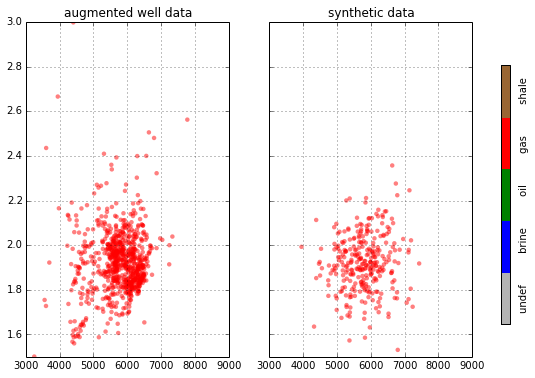

In [54]:
ww=pd.read_csv('WellData/qsiwell2_augmented.csv')
mc=pd.read_csv('WellData/qsiwell2_synthetic.csv')

def crossplot(n=1):
    f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 6))
    scatt1=ax[0].scatter(ww.IP[ww.LFC==n],ww.VPVS[ww.LFC==n],20,ww.LFC[ww.LFC==n],marker='o',edgecolors='none', alpha=0.5, cmap=cmap_facies,vmin=0,vmax=4)
    scatt2=ax[1].scatter(mc.IP[mc.LFC==n],mc.VPVS[mc.LFC==n],20,mc.LFC[mc.LFC==n],marker='o',edgecolors='none', alpha=0.5, cmap=cmap_facies,vmin=0,vmax=4)
    ax[0].set_xlim(3000,9000), ax[0].set_ylim(1.5,3.0)
    ax[0].set_title('augmented well data');
    ax[1].set_title('synthetic data');
    for i in range(len(ax)): ax[i].grid()  
    uu=f.add_axes([0.95, 0.2, 0.015, 0.6])
    cbar=f.colorbar(scatt2, cax=uu);
    cbar.set_label((10*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    cbar.set_alpha(1)
    cbar.draw_all()


    return n

interact(crossplot, n=(1,4))
print('Select Litho-Fluid Class: n=1 (brine), 2 (oil), 3 (gas), 4 (shale)')

We can also show a comparison between the Ip and Vp/Vs PDFs calculated for real (augmented) vs synthetic datasets, with the possibility to slide through the different classes.

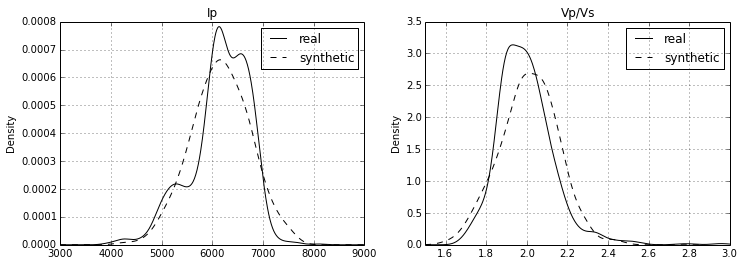

In [55]:
def histcompare(n):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    ww[ww.LFC==n]['IP'].plot(kind='density',style='k-',ax=ax[0],label='real',legend=True,title='Ip')
    mc[mc.LFC==n]['IP'].plot(kind='density',style='k--',ax=ax[0],label='synthetic',legend=True)
    ax[0].set_xlim(3000,9000)
    ww[ww.LFC==n]['VPVS'].plot(kind='density',style='k-',ax=ax[1],label='real',legend=True,title='Vp/Vs')
    mc[mc.LFC==n]['VPVS'].plot(kind='density',style='k--',ax=ax[1],label='synthetic',legend=True)
    ax[1].set_xlim(1.5,3.0)
    return n

interact(histcompare, n=(1,4))
print('Select Litho-Fluid Class: n=1 (brine), 2 (oil), 3 (gas), 4 (shale)')

# References

* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).
* Chambers, R., Yarus, J. & Hird, K. Petroleum geostatistics for nongeostatisticians - Part 1. The Leading Edge (2000).
* Mavko, G., Mukerji, T. & Dvorkin, J. The Rock Physics Handbook. (Cambridge University Press, 2009).
* Mukerji, T., Avseth, P., Mavko, G., Takahashi, I. & González, E. F. Statistical rock physics : Combining rock physics , information theory , and geostatistics to reduce uncertainty in seismic reservoir characterization. The Leading Edge 313–319 (2001).
* Smith, T. M., Sondergeld, C. H. & Rai, C. S. Gassmann fluid substitutions : A tutorial. Geophysics 68, 430–440 (2003).
* Wang, Z. Z. Fundamentals of seismic rock physics. Geophysics 66, 398–412 (2001).